In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


# Importing data and libraries

In [2]:
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
rs = 42

In [4]:
url = '../input/tabular-playground-series-may-2022/'
df = pd.read_csv(url+"train.csv")
test = pd.read_csv(url+'test.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

In [6]:
df.set_index("id",inplace=True)

In [7]:
test.set_index("id",inplace=True)

In [8]:
df.describe().loc[['min','max'],:]

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
min,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.0,0.0,0.0,...,-13.310146,-11.85353,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.0,0.0,0.0
max,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.0,16.0,14.0,...,14.455426,11.34408,12.247100,12.389844,12.529179,12.913041,1229.562577,1.0,2.0,1.0


# Memory Reduction

Since the number of training instances is large, model training and other processes will be slowed down. So it is best to reduce their sizes to the lowest level possible **without losing precision** of digits.

In [9]:
def reduce_memory(data,memory_size_int=8,memory_size_float=16):
    for col in data.columns:
        if str(data[col].dtype)[:1] == 'i':
            data[col] = data[col].astype(np.int8)
        elif str(data[col].dtype)[:1] == 'f':
            data[col] = data[col].astype(np.float16)
    return data
reduce_memory(data=df).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    900000 non-null  float16
 1   f_01    900000 non-null  float16
 2   f_02    900000 non-null  float16
 3   f_03    900000 non-null  float16
 4   f_04    900000 non-null  float16
 5   f_05    900000 non-null  float16
 6   f_06    900000 non-null  float16
 7   f_07    900000 non-null  int8   
 8   f_08    900000 non-null  int8   
 9   f_09    900000 non-null  int8   
 10  f_10    900000 non-null  int8   
 11  f_11    900000 non-null  int8   
 12  f_12    900000 non-null  int8   
 13  f_13    900000 non-null  int8   
 14  f_14    900000 non-null  int8   
 15  f_15    900000 non-null  int8   
 16  f_16    900000 non-null  int8   
 17  f_17    900000 non-null  int8   
 18  f_18    900000 non-null  int8   
 19  f_19    900000 non-null  float16
 20  f_20    900000 non-null  float16
 21  f_21    90

In [10]:
df = reduce_memory(data=df)

In [11]:
test = reduce_memory(data=test)

# EDA

<AxesSubplot:>

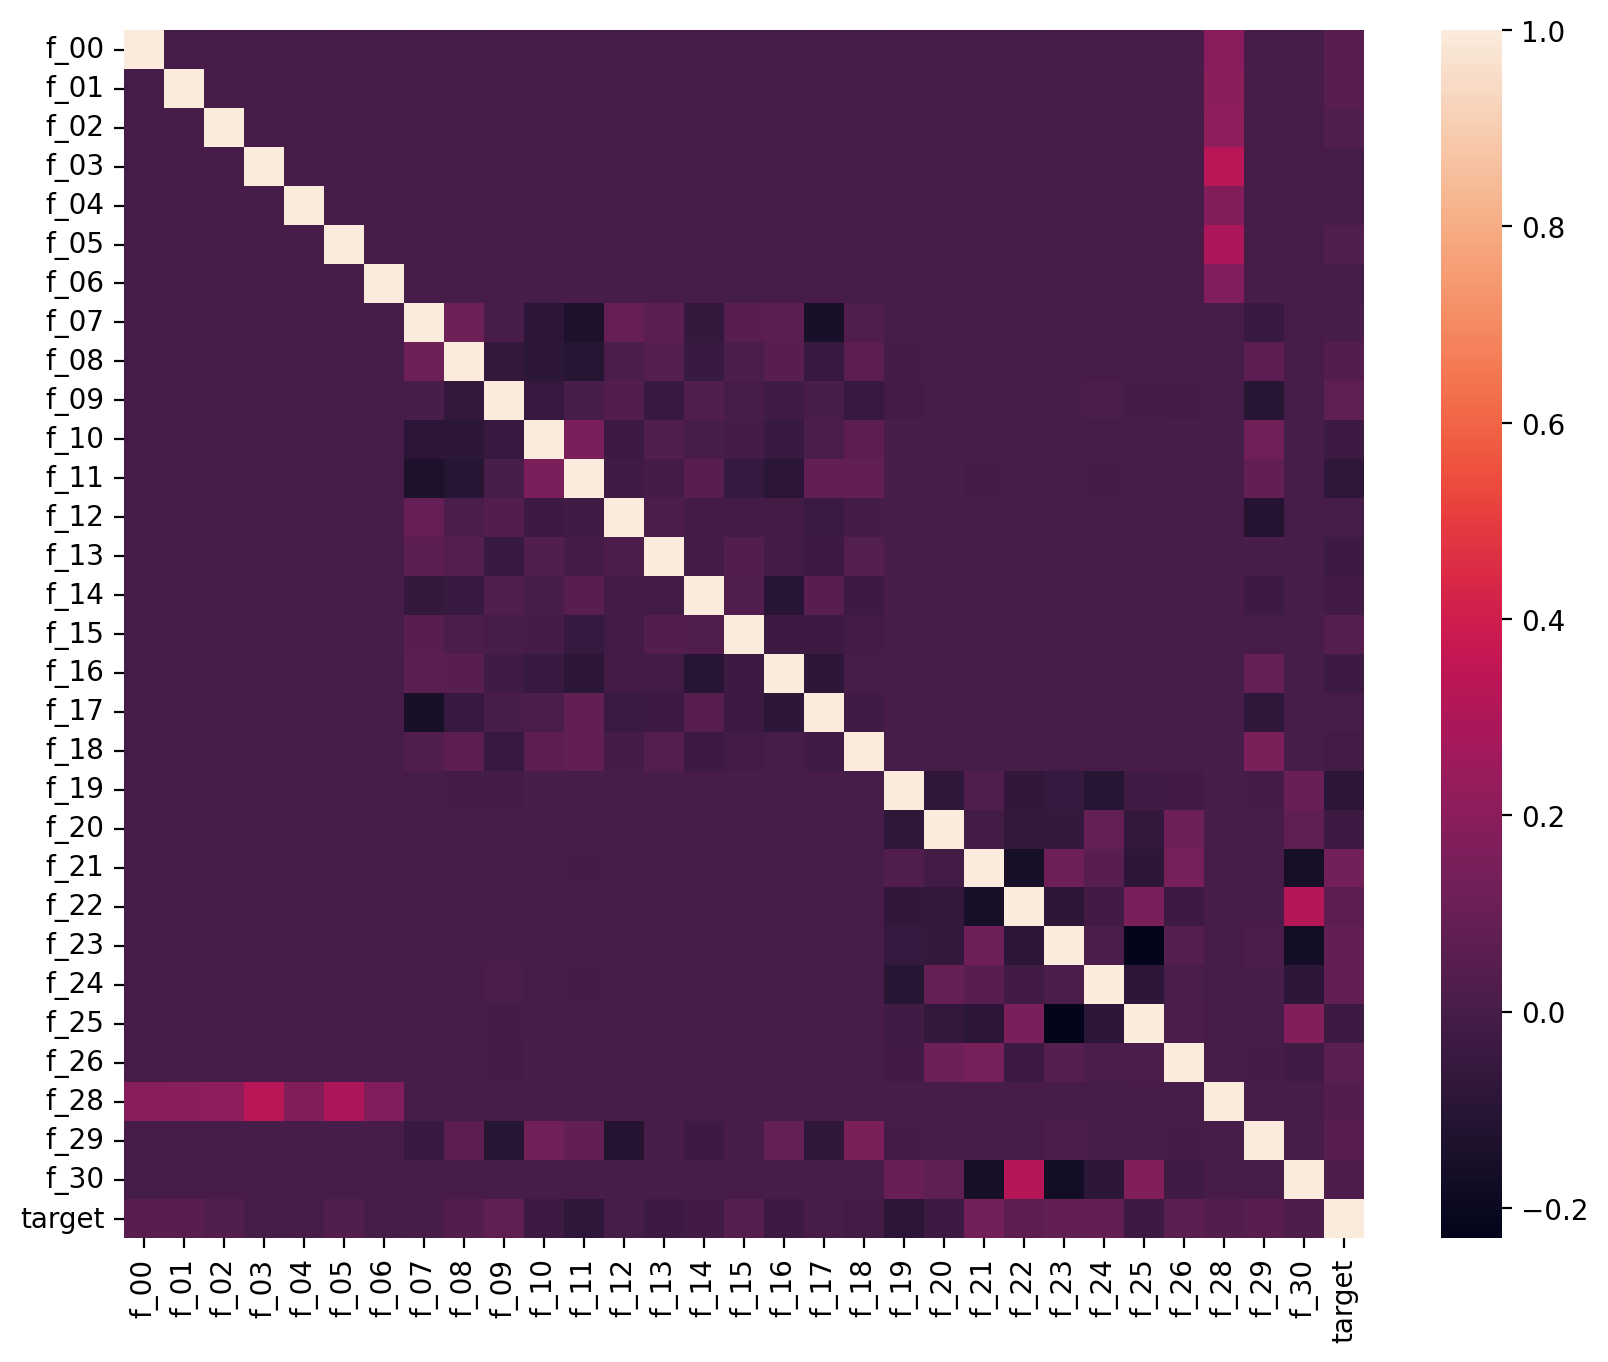

In [12]:
plt.figure(figsize=(10,8),dpi=200)
sns.heatmap(df.corr())

In [13]:
int_features = [col for col in df.columns if df[col].dtype==np.int8]
int_features.remove('target')
print(int_features)

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_29', 'f_30']


In [14]:
float_features = [col for col in df.columns if df[col].dtype==np.float16]
print(float_features)

['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28']


In [15]:
def plot_dists(data,cols,hue=None,bins=20,plot='hist'):
    n_rows = int(np.ceil(len(cols)/2))
    col = 0
    sns.set_style("whitegrid")
    fig,axes = plt.subplots(nrows=n_rows,ncols=2,figsize=(20,15))
    for i in range(n_rows):
        for j in range(2):
            if col > len(cols):
                axes[i][j].axis("off")
                break
            if plot=='hist':
                sns.histplot(x=cols[col],data=data,hue=hue,ax=axes[i][j],bins=bins)
                axes[i][j].set_title(f'Distribution of {cols[col]}',size=10)
            elif plot=='count':
                sns.countplot(x=cols[col],data=data,hue=hue,ax=axes[i][j])
                axes[i][j].set_title(f'Count of {cols[col]}',size=10)
            elif plot == 'kde':
                sns.kdeplot(x=cols[col],data=data,hue=hue,ax=axes[i][j])
                axes[i][j].set_title(f'Distribution of {cols[col]}',size=10)
            fig.tight_layout()
            col += 1

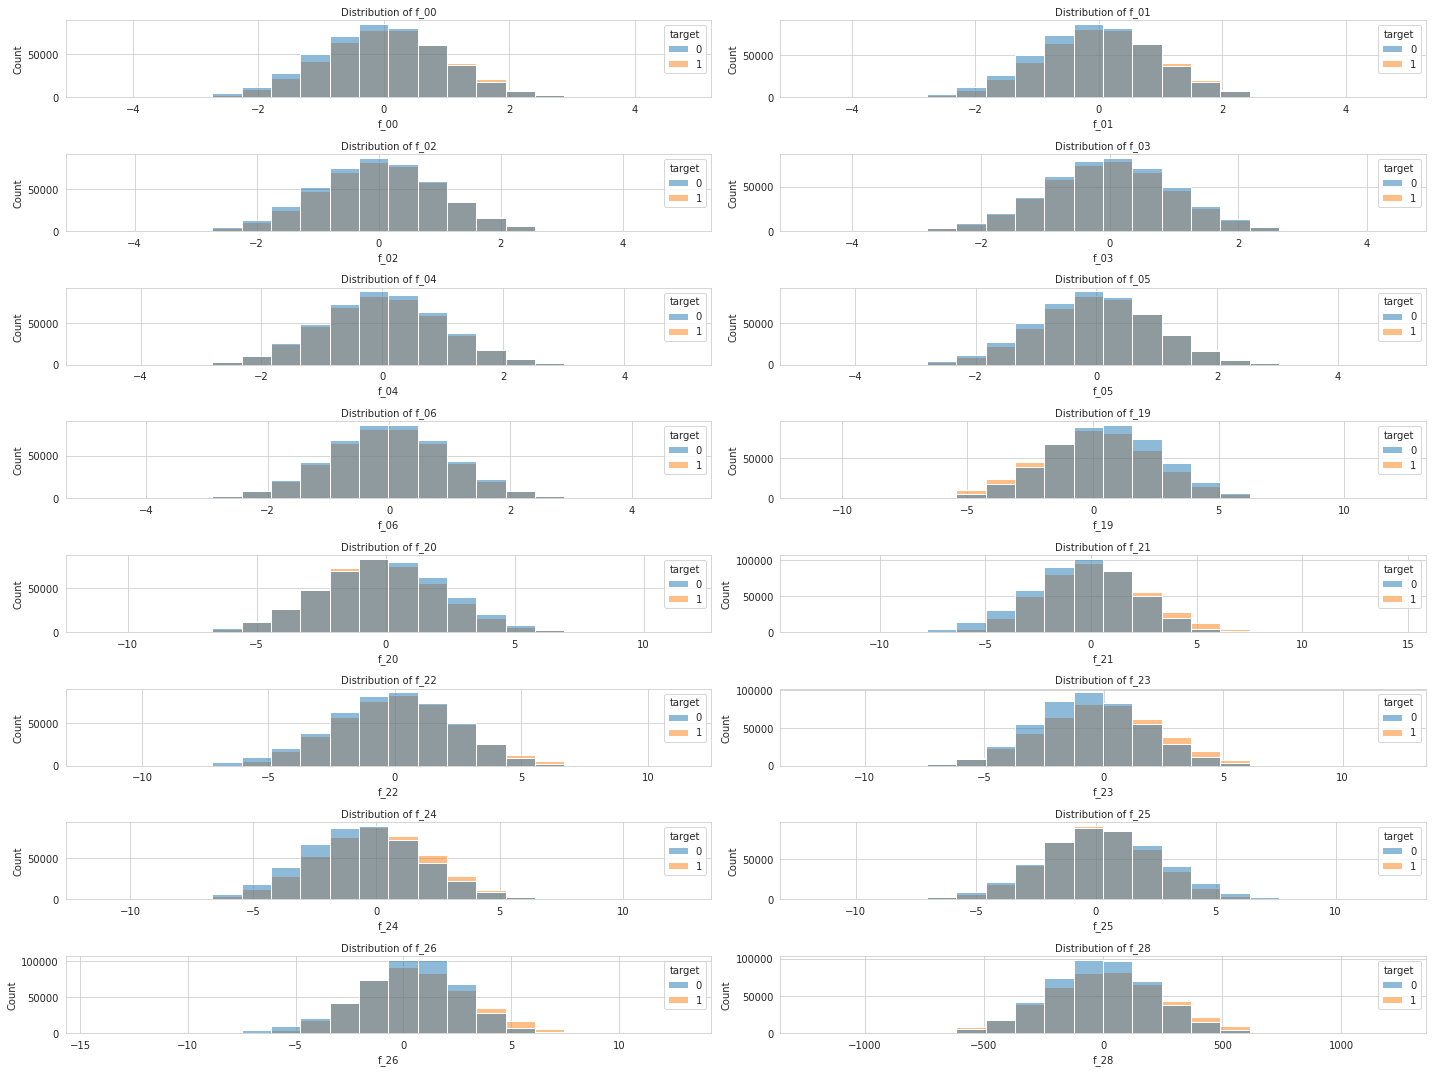

In [16]:
plot_dists(df,float_features,plot='hist',hue='target')

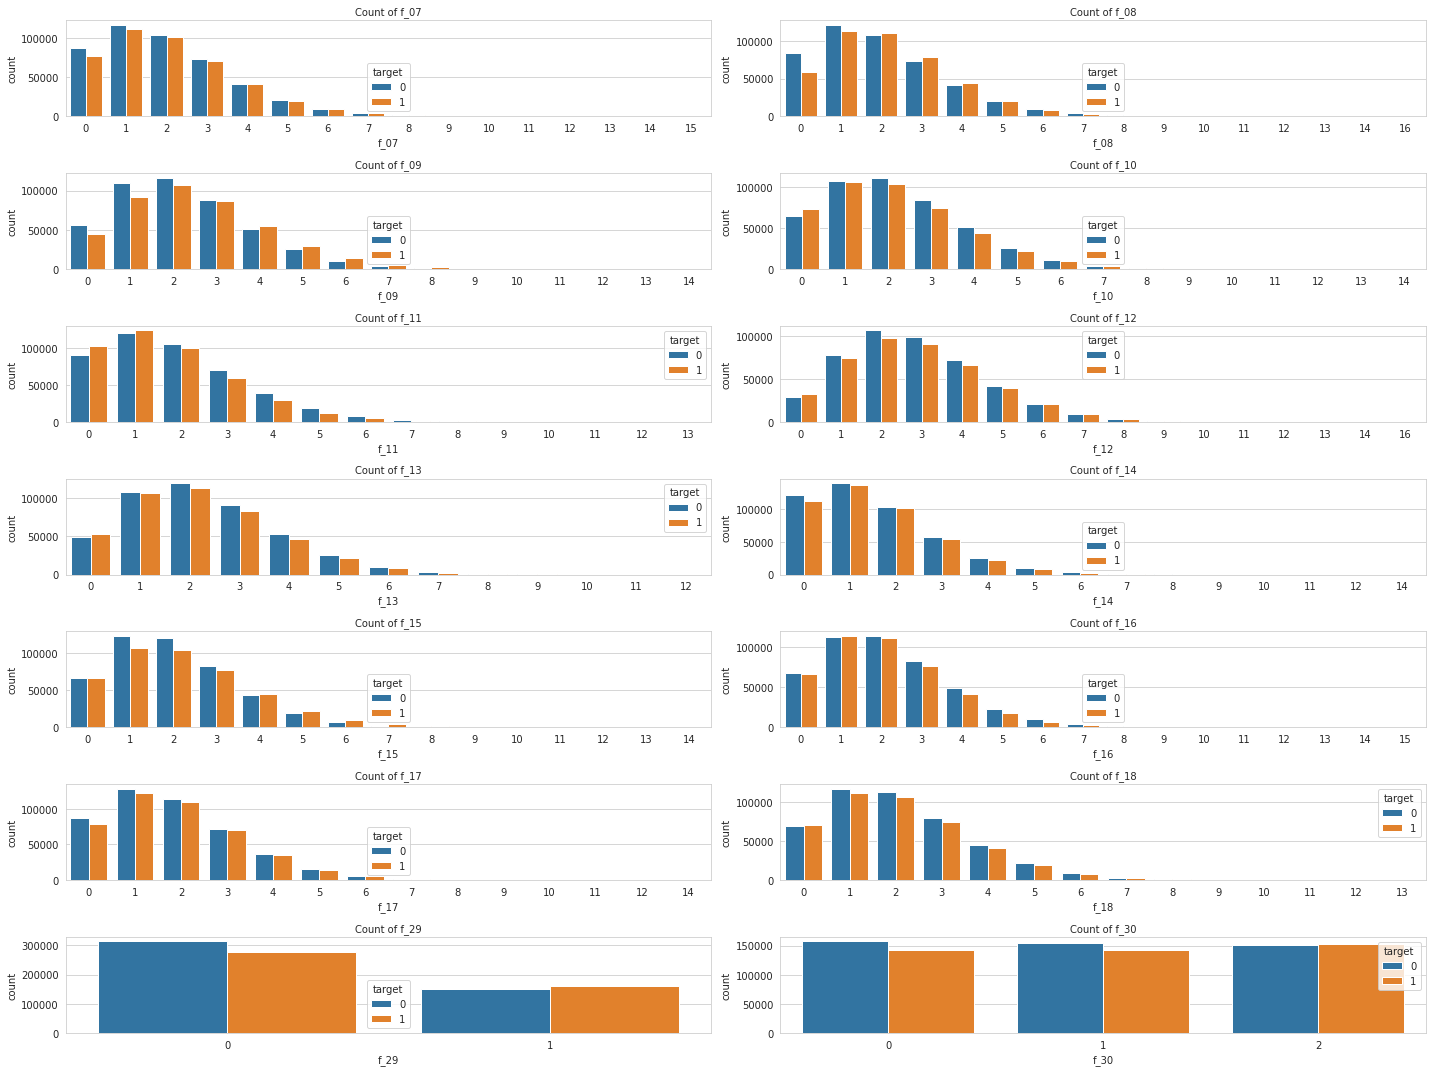

In [17]:
plot_dists(data=df,cols=int_features,plot='count',hue='target')

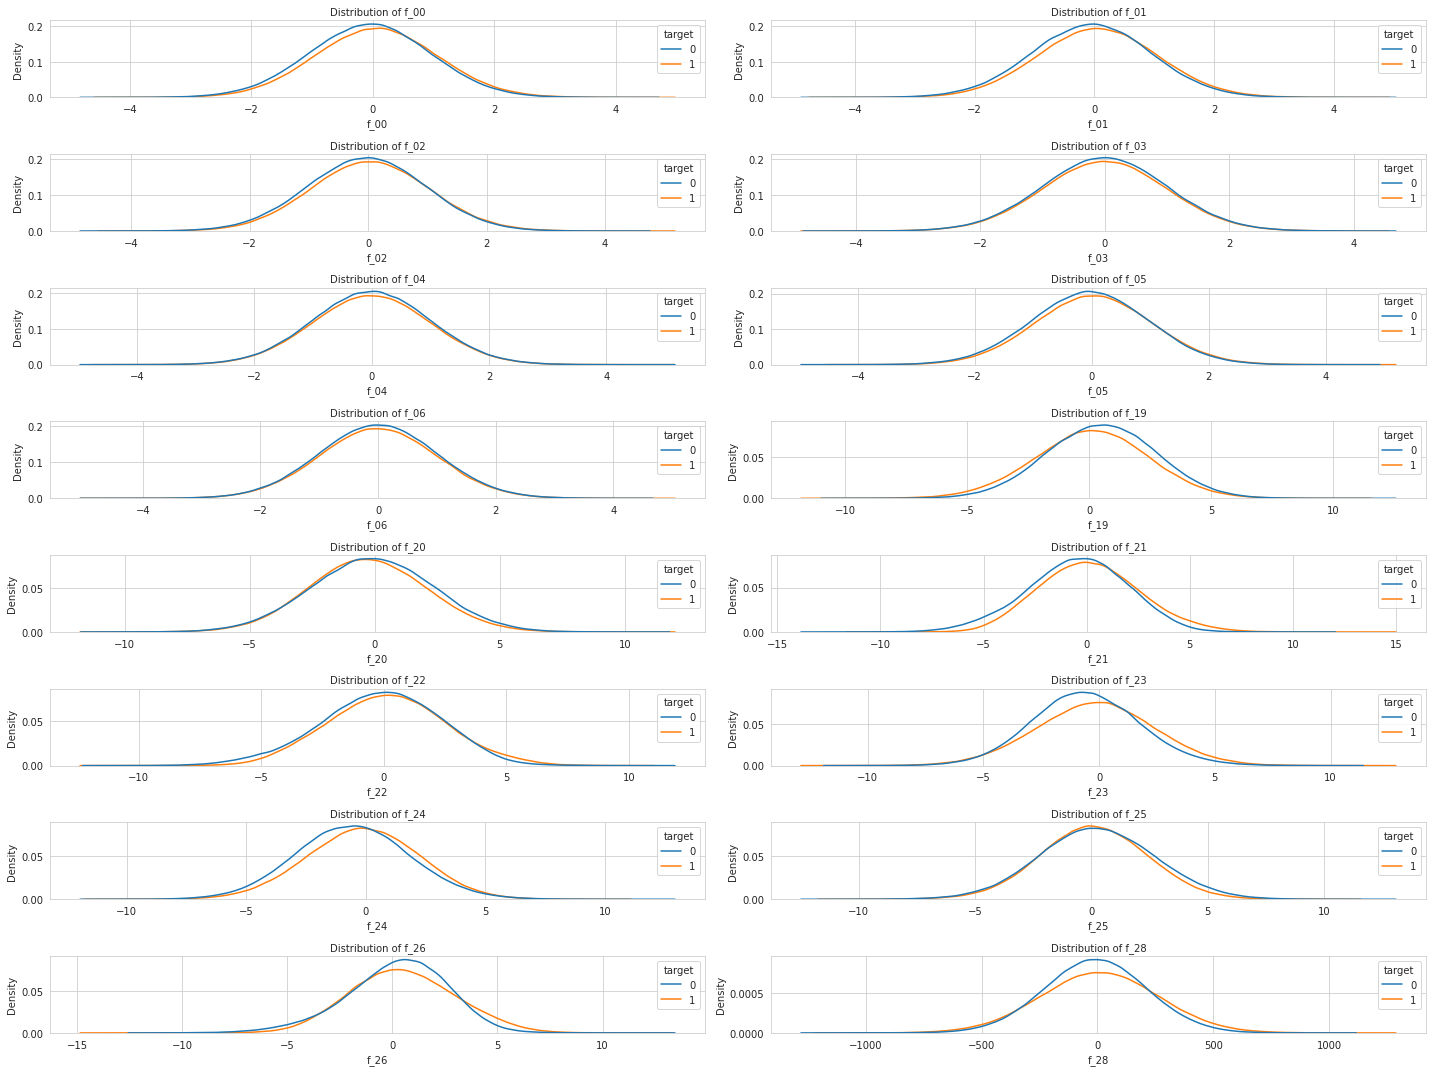

In [18]:
plot_dists(data=df,cols=float_features,plot='kde',hue='target')

In [19]:
df_corr = df.corr()

<AxesSubplot:>

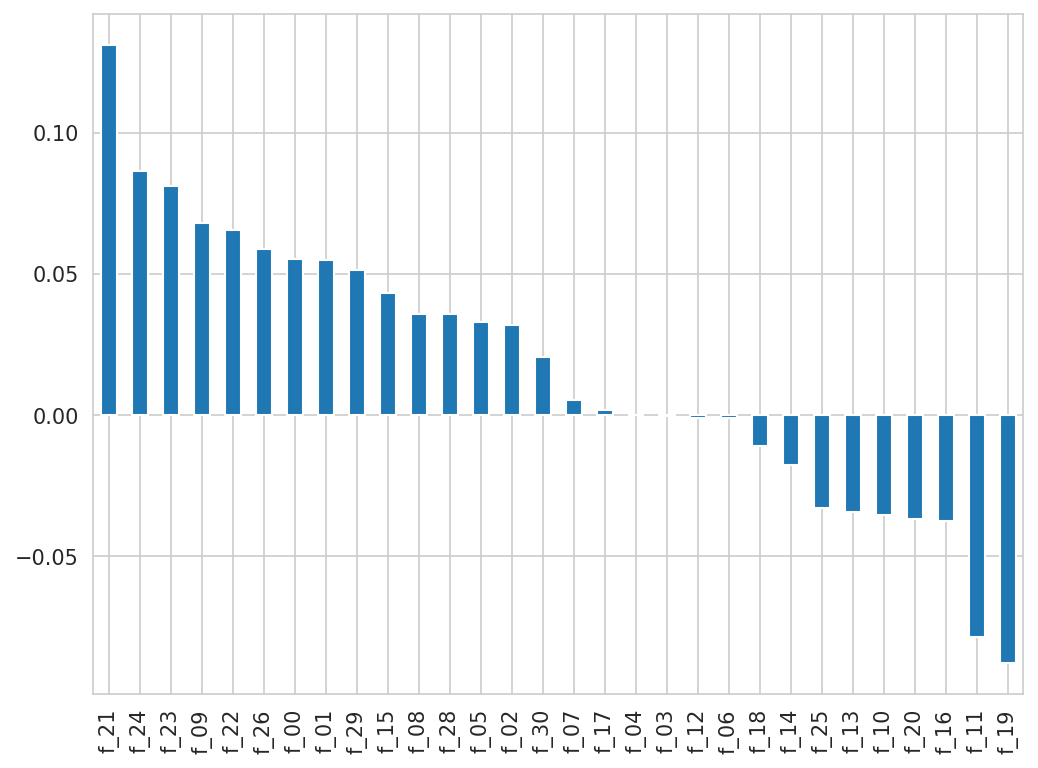

In [20]:
plt.figure(figsize=(8,6),dpi=150)
df_corr['target'].sort_values(ascending=False)[1:].plot(kind='bar')

In [21]:
pd.DataFrame(df_corr['target']).style.applymap(lambda x : f"color: {'red' if abs(x)<0.001 else 'green'}")

,target
f_00,0.055274
f_01,0.055011
f_02,0.031815
f_03,-0.000193
f_04,0.000159
f_05,0.033048
f_06,-0.000965
f_07,0.005257
f_08,0.035829
f_09,0.067909


*f_03, f_06, f_12* have very little correlation with target. Let's drop them

In [22]:
df.drop(['f_03','f_06','f_12'],axis=1,inplace=True)
test.drop(['f_03','f_06','f_12'],axis=1,inplace=True)

In [23]:
int_features = [col for col in df.columns if df[col].dtype==np.int8]
int_features.remove('target')
float_features = [col for col in df.columns if df[col].dtype==np.float16]

# Feature Engineering and Data Preparation

In [24]:
df["f_27"].value_counts()

BBBBBBCJBC    12
BCBBBBCLBC    12
BBBBBBDPCB    10
BBBBBBDKBC    10
ADBBBACQBC    10
              ..
BFAFAADTCE     1
BBBDAACOAE     1
BBABAACGBB     1
BFAABAGSDB     1
BCAACADSCE     1
Name: f_27, Length: 741354, dtype: int64

In [25]:
df['f_27'].str.split('',expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11
id,,,,,,,,,,,,
0,,A,B,A,B,D,A,D,B,A,B,
1,,A,C,A,C,C,A,D,C,E,B,
2,,A,A,A,E,A,B,C,K,A,D,
3,,B,D,B,B,A,A,C,B,C,B,
4,,B,D,B,C,B,B,C,H,F,E,
...,...,...,...,...,...,...,...,...,...,...,...,...
899995,,B,A,B,B,C,B,B,B,E,D,
899996,,B,B,B,G,B,B,D,Q,B,E,
899997,,A,E,B,E,D,B,B,H,B,A,


In [26]:
# adapted from https://www.kaggle.com/code/kotrying/tps22-05
df_split = df["f_27"].str.split('',expand=True).iloc[:,1:11]
df_split.columns = [f'f_27_{i}' for i in range(10)]
df_concat = pd.concat([df,df_split],axis=1)

In [27]:
test_split = test["f_27"].str.split('',expand=True).iloc[:,1:11]
test_split.columns = [f'f_27_{i}' for i in range(10)]
test_concat = pd.concat([test,test_split],axis=1)

In [28]:
df_concat.columns,test_concat.columns

(Index(['f_00', 'f_01', 'f_02', 'f_04', 'f_05', 'f_07', 'f_08', 'f_09', 'f_10',
        'f_11', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20',
        'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29',
        'f_30', 'target', 'f_27_0', 'f_27_1', 'f_27_2', 'f_27_3', 'f_27_4',
        'f_27_5', 'f_27_6', 'f_27_7', 'f_27_8', 'f_27_9'],
       dtype='object'),
 Index(['f_00', 'f_01', 'f_02', 'f_04', 'f_05', 'f_07', 'f_08', 'f_09', 'f_10',
        'f_11', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20',
        'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29',
        'f_30', 'f_27_0', 'f_27_1', 'f_27_2', 'f_27_3', 'f_27_4', 'f_27_5',
        'f_27_6', 'f_27_7', 'f_27_8', 'f_27_9'],
       dtype='object'))

In [29]:
def most_common(x):
    x = x.upper()
    set_x = set(x)
    count_high = 0
    letter_high = ''
    for letter in set_x:
        cnt = x.count(letter)
        if cnt>count_high:
            letter_high = letter
            count_high = cnt
    return letter_high
df['f_27'].apply(most_common).unique()
    

array(['B', 'C', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'],
      dtype=object)

In [30]:
df = df_concat.copy()
df['most_common'] = df['f_27'].apply(most_common)

In [31]:
test = test_concat.copy()
test['most_common'] = test['f_27'].apply(most_common)

In [32]:
obj_feats = [col for col in df.columns if df[col].dtype==object]
obj_feats.remove('f_27')
obj_feats

['f_27_0',
 'f_27_1',
 'f_27_2',
 'f_27_3',
 'f_27_4',
 'f_27_5',
 'f_27_6',
 'f_27_7',
 'f_27_8',
 'f_27_9',
 'most_common']

IndexError: list index out of range

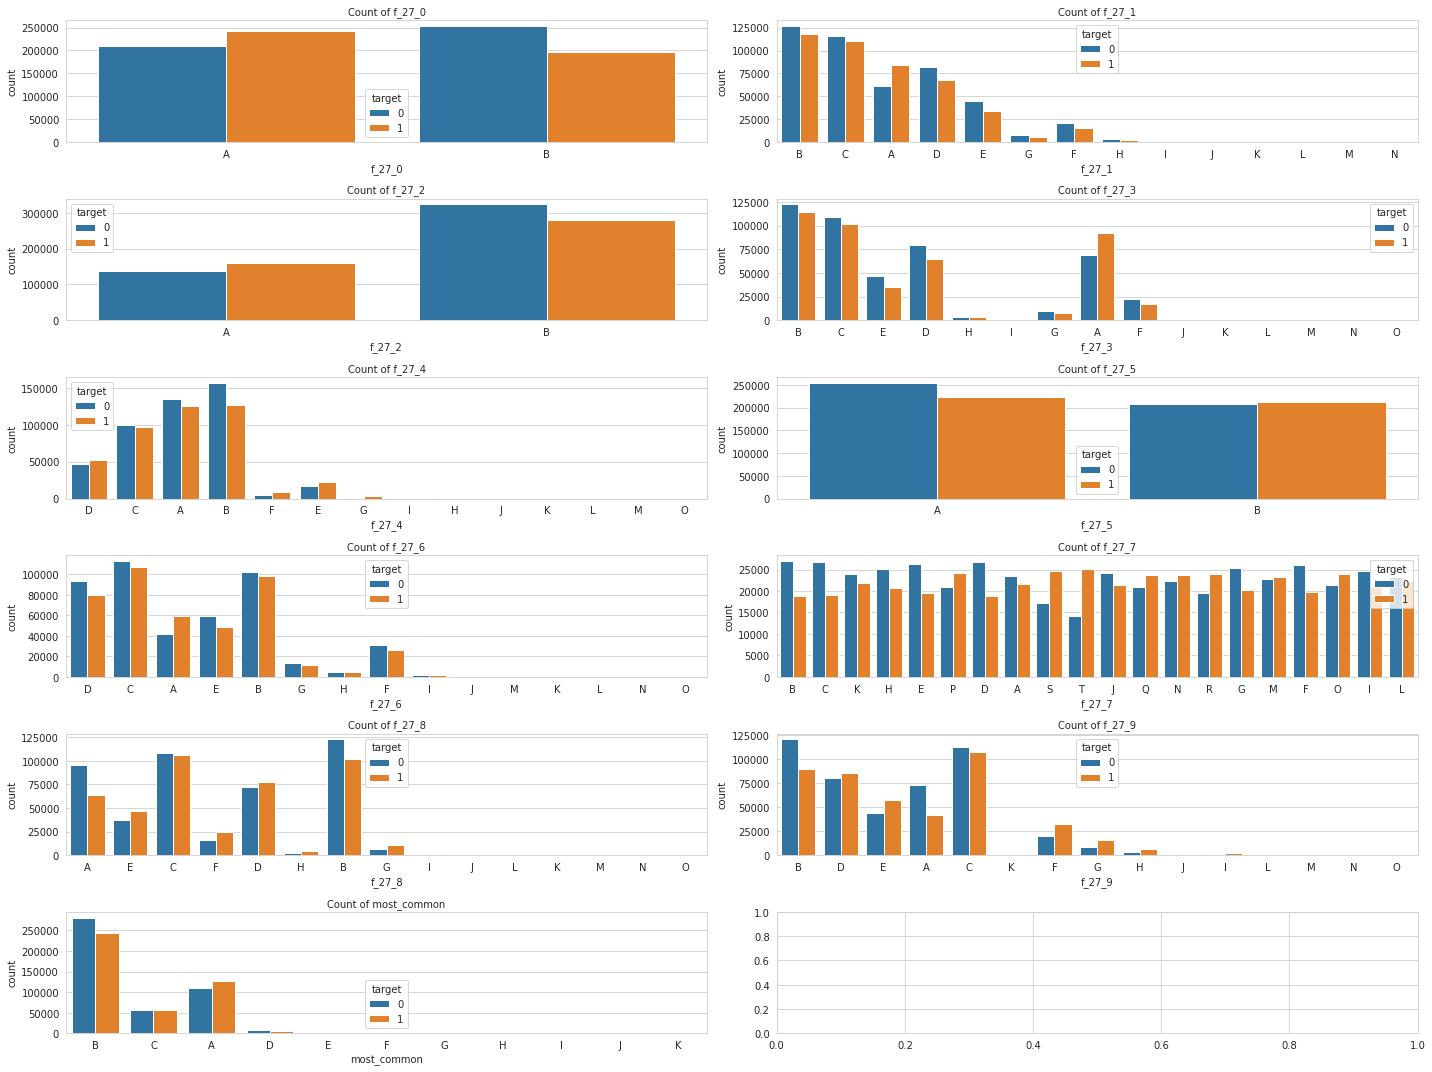

In [33]:
plot_dists(data=df,plot='count',hue='target',cols=obj_feats)

In [34]:
df.shape

(900000, 40)

In [35]:
df.drop('f_27',axis=1,inplace=True)

In [36]:
test.drop('f_27',axis=1,inplace=True)

In [37]:
for col in df.columns:
    if df[col].nunique()<=10:
        print(col)

f_29
f_30
target
f_27_0
f_27_2
f_27_5


In [38]:
df.loc[:,'f_27_0':]

,f_27_0,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,most_common
id,,,,,,,,,,,
0,A,B,A,B,D,A,D,B,A,B,B
1,A,C,A,C,C,A,D,C,E,B,C
2,A,A,A,E,A,B,C,K,A,D,A
3,B,D,B,B,A,A,C,B,C,B,B
4,B,D,B,C,B,B,C,H,F,E,B
...,...,...,...,...,...,...,...,...,...,...,...
899995,B,A,B,B,C,B,B,B,E,D,B
899996,B,B,B,G,B,B,D,Q,B,E,B
899997,A,E,B,E,D,B,B,H,B,A,B


In [39]:
df.loc[:,'f_27_0':].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   f_27_0       900000 non-null  object
 1   f_27_1       900000 non-null  object
 2   f_27_2       900000 non-null  object
 3   f_27_3       900000 non-null  object
 4   f_27_4       900000 non-null  object
 5   f_27_5       900000 non-null  object
 6   f_27_6       900000 non-null  object
 7   f_27_7       900000 non-null  object
 8   f_27_8       900000 non-null  object
 9   f_27_9       900000 non-null  object
 10  most_common  900000 non-null  object
dtypes: object(11)
memory usage: 114.6+ MB


In [40]:
for col in df.loc[:,'f_27_0':].columns:
    df[col] = df[col].apply(lambda x:ord(x)-64)
df.loc[:,'f_27_0':]

,f_27_0,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,most_common
id,,,,,,,,,,,
0,1,2,1,2,4,1,4,2,1,2,2
1,1,3,1,3,3,1,4,3,5,2,3
2,1,1,1,5,1,2,3,11,1,4,1
3,2,4,2,2,1,1,3,2,3,2,2
4,2,4,2,3,2,2,3,8,6,5,2
...,...,...,...,...,...,...,...,...,...,...,...
899995,2,1,2,2,3,2,2,2,5,4,2
899996,2,2,2,7,2,2,4,17,2,5,2
899997,1,5,2,5,4,2,2,8,2,1,2


In [41]:
for col in test.loc[:,'f_27_0':].columns:
    test[col] = test[col].apply(lambda x:ord(x)-64)
test.loc[:,'f_27_0':]

,f_27_0,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,most_common
id,,,,,,,,,,,
900000,2,1,1,1,2,1,4,12,1,3,1
900001,1,6,1,2,2,1,5,7,3,2,2
900002,2,2,1,3,1,2,2,11,5,5,2
900003,1,5,2,5,1,1,3,17,3,3,3
900004,1,5,2,2,2,2,4,1,2,6,2
...,...,...,...,...,...,...,...,...,...,...,...
1599995,2,3,2,3,5,2,8,13,3,4,3
1599996,2,1,1,2,3,1,4,17,6,3,1
1599997,1,1,1,10,3,2,7,17,2,1,1


In [42]:
df.columns

Index(['f_00', 'f_01', 'f_02', 'f_04', 'f_05', 'f_07', 'f_08', 'f_09', 'f_10',
       'f_11', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20',
       'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28', 'f_29', 'f_30',
       'target', 'f_27_0', 'f_27_1', 'f_27_2', 'f_27_3', 'f_27_4', 'f_27_5',
       'f_27_6', 'f_27_7', 'f_27_8', 'f_27_9', 'most_common'],
      dtype='object')

In [70]:
X,y = df.drop(['target'],axis=1),df["target"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=rs)

In [71]:
X_train.shape

(630000, 38)

In [72]:
X_train = X_train.values
X_test = X_test.values

# Modelling

## Classical ML models

### DecisionTree and RandomForest

In [46]:
dtr = DecisionTreeClassifier(max_depth=5)
scores = cross_val_score(estimator=dtr,X=X_train,y=y_train,cv=5)

In [47]:
print(scores)

[0.66807937 0.66419841 0.6628254  0.66664286 0.66393651]


In [48]:
rf = RandomForestClassifier(n_estimators=20)
scores = cross_val_score(estimator=rf,X=X_train,y=y_train,cv=5)
print(scores)

[0.81814286 0.81896825 0.81450794 0.8173254  0.8155873 ]


In [49]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### RandomForest GridSearch

In [ ]:
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth' : [4,5,6],
    'n_estimators' : [100,150]
}

gs = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=5)
gs = gs.fit(X_train,y_train)

In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_

In [ ]:
gs.best_params_

## Monitoring Overfitting

In [53]:
def plot_2(x,y,z,label_y,label_z,title):
    plt.plot(x,y,'b-',label=label_y)
    plt.plot(x,z,'r--',label=label_z)
    plt.title(title)
    plt.legend()
def train_validation_curve_for_rf(X,y,val_size=0.3,rs=42,epochs=10,n_estimators=False,max_depth=True,
                                 max_depth_start=6,n_estimators_start=100,criterion='gini'):
    from sklearn.metrics import accuracy_score,precision_score,recall_score
    X_tr,X_val,y_tr,y_val = train_test_split(X,y,test_size=val_size,random_state=rs)
    acc_tr,acc_val = [],[]
    pr_tr,pr_val = [],[]
    rec_tr,rec_val = [],[]
    if max_depth:
        for depth in range(max_depth_start,max_depth_start+epochs):
            rf = RandomForestClassifier(criterion=criterion,max_depth=depth,n_estimators=100)
            rf = rf.fit(X_tr,y_tr)
            pred_tr = rf.predict(X_tr)
            pred_val = rf.predict(X_val)
            acc_tr.append(accuracy_score(y_tr,pred_tr))
            acc_val.append(accuracy_score(y_val,pred_val))
            pr_tr.append(precision_score(y_tr,pred_tr))
            pr_val.append(precision_score(y_val,pred_val))
            rec_tr.append(recall_score(y_tr,pred_tr))
            rec_val.append(recall_score(y_val,pred_val))
        fig,ax = plt.subplots(nrows=3,figsize=(10,8))
        plt.sca(ax[0])
        plot_2([x for x in range(max_depth_start,max_depth_start+epochs)],acc_tr,acc_val,'train','val','train/val accuracy')
        plt.sca(ax[1])
        plot_2([x for x in range(max_depth_start,max_depth_start+epochs)],pr_tr,pr_val,'train','val','train/val precision')
        plt.sca(ax[2])
        plot_2([x for x in range(max_depth_start,max_depth_start+epochs)],rec_tr,rec_val,'train','val','train/val recall')
    elif n_estimators:
        for n_estimator in range(n_estimators_start,n_estimators_start+epochs,int(np.ceil(epochs/10))):
            rf = RandomForestClassifier(criterion=criterion,max_depth=6,n_estimators=n_estimator)
            rf = rf.fit(X_tr,y_tr)
            pred_tr = rf.predict(X_tr)
            pred_val = rf.predict(X_val)
            acc_tr.append(accuracy_score(y_tr,pred_tr))
            acc_val.append(accuracy_score(y_val,pred_val))
            pr_tr.append(precision_score(y_tr,pred_tr))
            pr_val.append(precision_score(y_val,pred_val))
            rec_tr.append(recall_score(y_tr,pred_tr))
            rec_val.append(recall_score(y_val,pred_val))
        fig,ax = plt.subplots(nrows=3,figsize=(10,8))
        plt.sca(ax[0])
        plot_2([x for x in range(n_estimators_start,n_estimators_start+epochs,int(np.ceil(epochs/10)))],
               acc_tr,acc_val,'train','val','train/val accuracy')
        plt.sca(ax[1])
        plot_2([x for x in range(n_estimators_start,n_estimators_start+epochs,int(np.ceil(epochs/10)))],
               pr_tr,pr_val,'train','val','train/val precision')
        plt.sca(ax[2])
        plot_2([x for x in range(n_estimators_start,n_estimators_start+epochs,int(np.ceil(epochs/10)))],
               rec_tr,rec_val,'train','val','train/val recall')

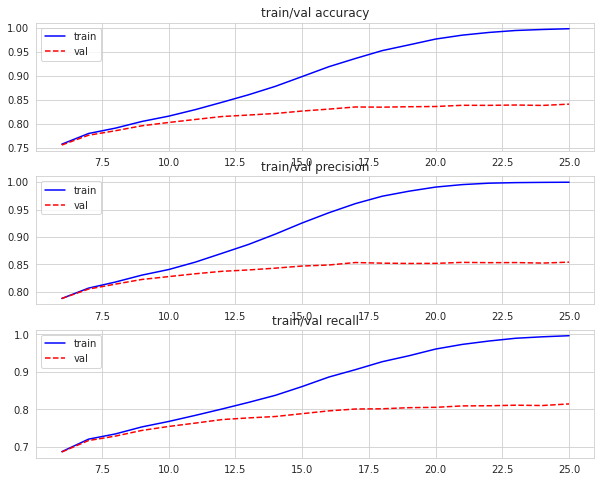

In [51]:
train_validation_curve_for_rf(X=X_train,y=y_train,epochs=20)

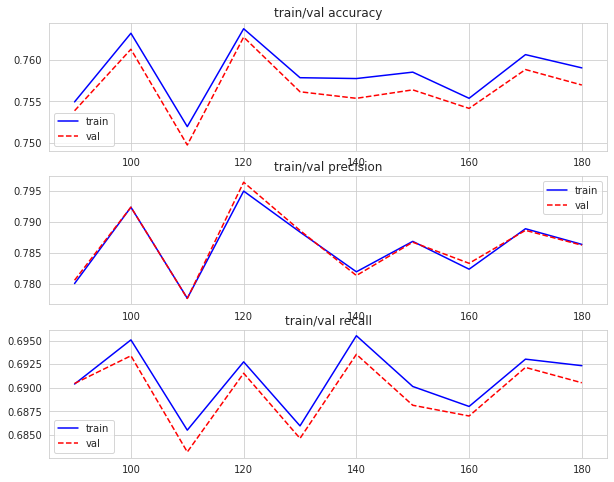

In [52]:
train_validation_curve_for_rf(X=X_train,y=y_train,n_estimators=True,n_estimators_start=90,
                       epochs=100,max_depth=False)

From the above plots **max_depth of 14** and **n_estimators of 160** should be the ideal parameters for the baseline model

## DL model

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [55]:
def build_model(units=128,lower_thresh=16,activation="selu",kernel_initializer="lecun_normal",
               optimizer="adam",metrics="accuracy"):
    model = tf.keras.models.Sequential()
    while units>=lower_thresh:
        model.add(layers.Dense(units=units,activation=activation,kernel_initializer=kernel_initializer))
        units = int(units/2)
    model.add(layers.Dense(1,activation="sigmoid"))
    
    model.compile(loss="binary_crossentropy",optimizer=optimizer,
                 metrics=metrics)
    
    return model

In [73]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [57]:
model_1 = build_model()

2022-05-05 14:12:41.846940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 14:12:41.957450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 14:12:41.958364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 14:12:41.959631: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [58]:
history_1 = model_1.fit(X_train_sc,y_train,epochs=20,validation_split=0.2)

2022-05-05 14:12:44.577173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
15750/15750 [==============================] - 45s 3ms/step - loss: 0.3828 - accuracy: 0.8286 - val_loss: 0.3208 - val_accuracy: 0.8620
Epoch 2/20
15750/15750 [==============================] - 44s 3ms/step - loss: 0.2920 - accuracy: 0.8743 - val_loss: 0.2738 - val_accuracy: 0.8819
Epoch 3/20
15750/15750 [==============================] - 39s 3ms/step - loss: 0.2553 - accuracy: 0.8921 - val_loss: 0.2515 - val_accuracy: 0.8942
Epoch 4/20
15750/15750 [==============================] - 38s 2ms/step - loss: 0.2350 - accuracy: 0.9016 - val_loss: 0.2356 - val_accuracy: 0.9004
Epoch 5/20
15750/15750 [==============================] - 43s 3ms/step - loss: 0.2225 - accuracy: 0.9069 - val_loss: 0.2233 - val_accuracy: 0.9068
Epoch 6/20
15750/15750 [==============================] - 43s 3ms/step - loss: 0.2137 - accuracy: 0.9109 - val_loss: 0.2158 - val_accuracy: 0.9108
Epoch 7/20
15750/15750 [==============================] - 39s 2ms/step - loss: 0.2072 - accuracy: 0.9139 - val_loss: 0

In [59]:
model_1_df = pd.DataFrame(history_1.history)

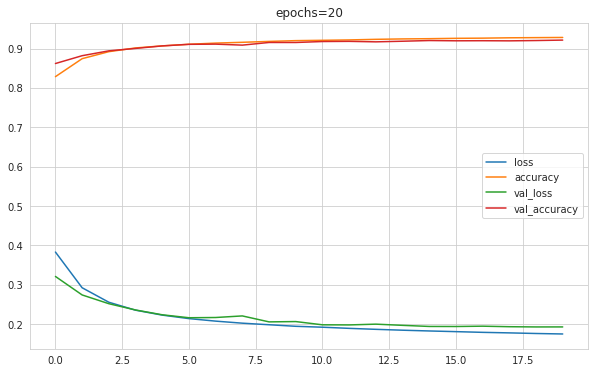

In [60]:
model_1_df.plot(figsize=(10,6))
plt.title("epochs=20");

In [61]:
model_2 = build_model(units=256)
early_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
history_2 = model_2.fit(X_train_sc,y_train,epochs=40,
                       validation_split=0.2,
                       callbacks=[early_cb])

Epoch 1/40
15750/15750 [==============================] - 45s 3ms/step - loss: 0.3519 - accuracy: 0.8446 - val_loss: 0.2900 - val_accuracy: 0.8744
Epoch 2/40
15750/15750 [==============================] - 40s 3ms/step - loss: 0.2591 - accuracy: 0.8904 - val_loss: 0.2406 - val_accuracy: 0.8992
Epoch 3/40
15750/15750 [==============================] - 45s 3ms/step - loss: 0.2290 - accuracy: 0.9045 - val_loss: 0.2251 - val_accuracy: 0.9063
Epoch 4/40
15750/15750 [==============================] - 45s 3ms/step - loss: 0.2122 - accuracy: 0.9123 - val_loss: 0.2107 - val_accuracy: 0.9135
Epoch 5/40
15750/15750 [==============================] - 40s 3ms/step - loss: 0.2016 - accuracy: 0.9167 - val_loss: 0.2044 - val_accuracy: 0.9151
Epoch 6/40
15750/15750 [==============================] - 45s 3ms/step - loss: 0.1944 - accuracy: 0.9201 - val_loss: 0.2103 - val_accuracy: 0.9124
Epoch 7/40
15750/15750 [==============================] - 46s 3ms/step - loss: 0.1890 - accuracy: 0.9225 - val_loss: 0

In [62]:
model_2_df = pd.DataFrame(history_2.history)

Text(0.5, 1.0, 'epochs=40, stopped at 27')

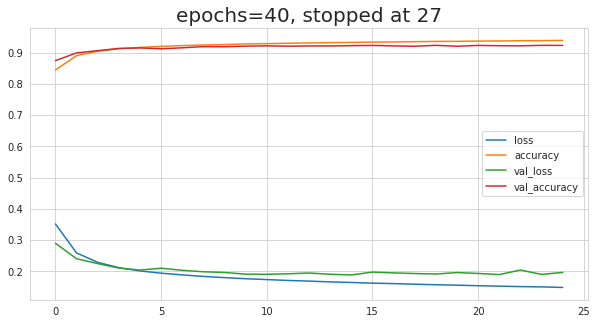

In [63]:
model_2_df.plot(figsize=(10,5))
plt.title("epochs=40, stopped at 27",size=20)

In [64]:
model_3 = build_model(units=256,optimizer="nadam")
history_3 = model_3.fit(X_train_sc,y_train,epochs=20,validation_split=0.2)

Epoch 1/20
15750/15750 [==============================] - 63s 4ms/step - loss: 0.3523 - accuracy: 0.8435 - val_loss: 0.2811 - val_accuracy: 0.8802
Epoch 2/20
15750/15750 [==============================] - 62s 4ms/step - loss: 0.2584 - accuracy: 0.8910 - val_loss: 0.2526 - val_accuracy: 0.8948
Epoch 3/20
15750/15750 [==============================] - 67s 4ms/step - loss: 0.2282 - accuracy: 0.9053 - val_loss: 0.2232 - val_accuracy: 0.9082
Epoch 4/20
15750/15750 [==============================] - 66s 4ms/step - loss: 0.2112 - accuracy: 0.9125 - val_loss: 0.2120 - val_accuracy: 0.9119
Epoch 5/20
15750/15750 [==============================] - 68s 4ms/step - loss: 0.2007 - accuracy: 0.9173 - val_loss: 0.2037 - val_accuracy: 0.9160
Epoch 6/20
15750/15750 [==============================] - 63s 4ms/step - loss: 0.1936 - accuracy: 0.9204 - val_loss: 0.1959 - val_accuracy: 0.9180
Epoch 7/20
15750/15750 [==============================] - 66s 4ms/step - loss: 0.1880 - accuracy: 0.9224 - val_loss: 0

In [65]:
model_3_df = pd.DataFrame(history_3.history)

Text(0.5, 1.0, 'nadam')

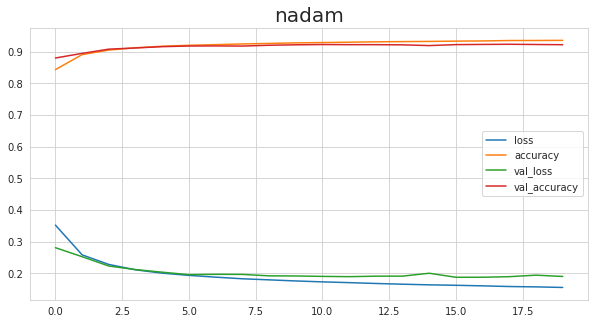

In [66]:
model_3_df.plot(figsize=(10,5))
plt.title("nadam",size=20)

In [67]:
model_1_df.val_accuracy.max(),model_2_df.val_accuracy.max(),model_3_df.val_accuracy.max()

(0.9215555787086487, 0.9233015775680542, 0.9236031770706177)

In [74]:
model_4 = build_model(units=256,optimizer="nadam",kernel_initializer="he_normal",activation="elu")
history_4 = model_4.fit(X_train_sc,y_train,epochs=20,validation_split=0.2)

Epoch 1/20
15750/15750 [==============================] - 68s 4ms/step - loss: 0.3293 - accuracy: 0.8556 - val_loss: 0.2671 - val_accuracy: 0.8874
Epoch 2/20
15750/15750 [==============================] - 61s 4ms/step - loss: 0.2474 - accuracy: 0.8956 - val_loss: 0.2358 - val_accuracy: 0.9022
Epoch 3/20
15750/15750 [==============================] - 62s 4ms/step - loss: 0.2183 - accuracy: 0.9091 - val_loss: 0.2102 - val_accuracy: 0.9120
Epoch 4/20
15750/15750 [==============================] - 66s 4ms/step - loss: 0.2044 - accuracy: 0.9155 - val_loss: 0.2100 - val_accuracy: 0.9123
Epoch 5/20
15750/15750 [==============================] - 62s 4ms/step - loss: 0.1958 - accuracy: 0.9193 - val_loss: 0.2013 - val_accuracy: 0.9167
Epoch 6/20
15750/15750 [==============================] - 67s 4ms/step - loss: 0.1889 - accuracy: 0.9222 - val_loss: 0.2010 - val_accuracy: 0.9163
Epoch 7/20
15750/15750 [==============================] - 67s 4ms/step - loss: 0.1835 - accuracy: 0.9244 - val_loss: 0

Text(0.5, 1.0, 'nadam+elu')

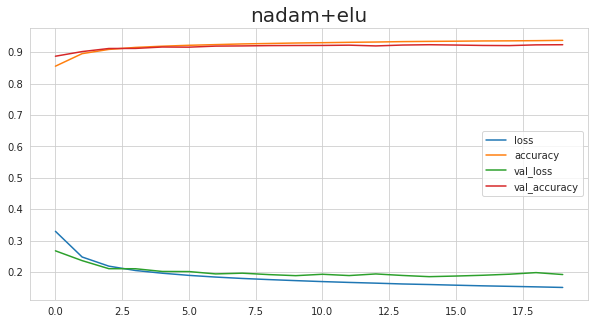

In [75]:
model_4_df = pd.DataFrame(history_4.history)
model_4_df.plot(figsize=(10,5))
plt.title("nadam+elu",size=20)

In [76]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(np.r_[X_train,X_test])

In [77]:
nn_model = build_model(units=256,optimizer="nadam")
early_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
nn_model.fit(X_train_sc,np.r_[y_train,y_test],epochs=30,
            callbacks=[early_cb])

Epoch 1/30
28125/28125 [==============================] - 101s 4ms/step - loss: 0.3108 - accuracy: 0.8646
Epoch 2/30
28125/28125 [==============================] - 99s 4ms/step - loss: 0.2265 - accuracy: 0.9057
Epoch 3/30
28125/28125 [==============================] - 100s 4ms/step - loss: 0.2041 - accuracy: 0.9157
Epoch 4/30
28125/28125 [==============================] - 100s 4ms/step - loss: 0.1928 - accuracy: 0.9208
Epoch 5/30
28125/28125 [==============================] - 100s 4ms/step - loss: 0.1856 - accuracy: 0.9237
Epoch 6/30
28125/28125 [==============================] - 100s 4ms/step - loss: 0.1809 - accuracy: 0.9258
Epoch 7/30
28125/28125 [==============================] - 100s 4ms/step - loss: 0.1773 - accuracy: 0.9274
Epoch 8/30
28125/28125 [==============================] - 100s 4ms/step - loss: 0.1737 - accuracy: 0.9287
Epoch 9/30
28125/28125 [==============================] - 101s 4ms/step - loss: 0.1712 - accuracy: 0.9299
Epoch 10/30
28125/28125 [======================

In [78]:
test

,f_00,f_01,f_02,f_04,f_05,f_07,f_08,f_09,f_10,f_11,...,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,most_common
id,,,,,,,,,,,,,,,,,,,,,
900000,0.442627,0.174438,-1.000000,0.186768,-1.075195,6,6,0,0,0,...,1,1,1,2,1,4,12,1,3,1
900001,-0.605469,-0.305664,0.627441,-1.750977,1.355469,1,3,4,0,2,...,6,1,2,2,1,5,7,3,2,2
900002,0.303955,2.445312,0.246460,0.359619,-1.332031,3,3,4,1,1,...,2,1,3,1,2,2,11,5,5,2
900003,0.154053,0.260010,-1.367188,-1.111328,-0.948242,0,0,4,2,1,...,5,2,5,1,1,3,17,3,3,3
900004,-1.652344,-0.424316,-0.667480,-0.089478,0.181763,2,2,2,0,0,...,5,2,2,2,2,4,1,2,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,0.640137,0.897949,-0.523926,-0.092285,-0.610840,0,1,6,2,5,...,3,2,3,5,2,8,13,3,4,3
1599996,-0.191772,-0.035248,-0.118530,2.126953,0.568848,4,3,4,2,0,...,1,1,2,3,1,4,17,6,3,1
1599997,-0.331787,-0.328857,-1.185547,-0.483154,-0.107117,1,1,2,1,1,...,1,1,10,3,2,7,17,2,1,1


In [79]:
final_test = test.values

In [80]:
final_test = sc.transform(final_test)

In [81]:
pred = nn_model.predict(final_test)

In [82]:
test["target"] = pred

In [83]:
sub = test.loc[:,"target":]

In [84]:
sub.to_csv("submission.csv")